In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['champs-scalar-coupling', 'prepare-dataset-rdkit-rev-2']


In [2]:
#Load sub data
mol_dataset= pd.read_csv("../input/prepare-dataset-rdkit-rev-2/mol_dataset.csv")
#mol_dataset= pd.read_csv("../input/prepare-dataset-rdkit-rev-2/mol_dataset.csv")
mol_dataset.head(5)

,molecule_name,mol_data,smiles,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,dsgdb9nsd_000001,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1c60>,C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000002,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1da0>,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000003,<rdkit.Chem.rdchem.Mol object at 0x7f2e52743f80>,O,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000005,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1e90>,C#N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000007,<rdkit.Chem.rdchem.Mol object at 0x7f2e531d1f30>,CC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#reduce data size
mol_dataset = reduce_mem_usage(mol_dataset)

Mem. usage decreased to 60.74 Mb (83.5% reduction)


In [4]:
#cut string data
mol_dataset = mol_dataset.drop(['mol_data' , 'smiles'], axis=1)
mol_dataset.head(5)

#mol_fingerprint = mol_dataset.iloc[:,3:170]
#mol_fingerptint.shape

#mol_descriptor = mol_dataset.iloc[:,171:370]
#mol_descriptor.shape

,molecule_name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,dsgdb9nsd_000001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dsgdb9nsd_000002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,dsgdb9nsd_000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,dsgdb9nsd_000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,dsgdb9nsd_000007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
mol_name = mol_dataset["molecule_name"]
mol_dataset = mol_dataset.iloc[:,1:368]
#mol_high_std

There are a lot of 0 or 1 data, and no variance columns.  
In addition, low std columns means that there are high bias of data. If this bias is too high, sometime set up bad effect when do CV. If we do 5-fold CV, we sould remove the columns which contain over 80% same data such as 0, 1.

reference:  
https://datachemeng.com/deletedescriptors/  
https://datachemeng.com/wp-content/uploads/2017/09/basicdatapreprocessing.pdf

According to result of LightGBM_using_new_features_rev.0, many of parameters don't have strong impact for model.  
So in rev.1 we try to use only top 20 of fingerprints and descriptors. (Rough parameter selection)

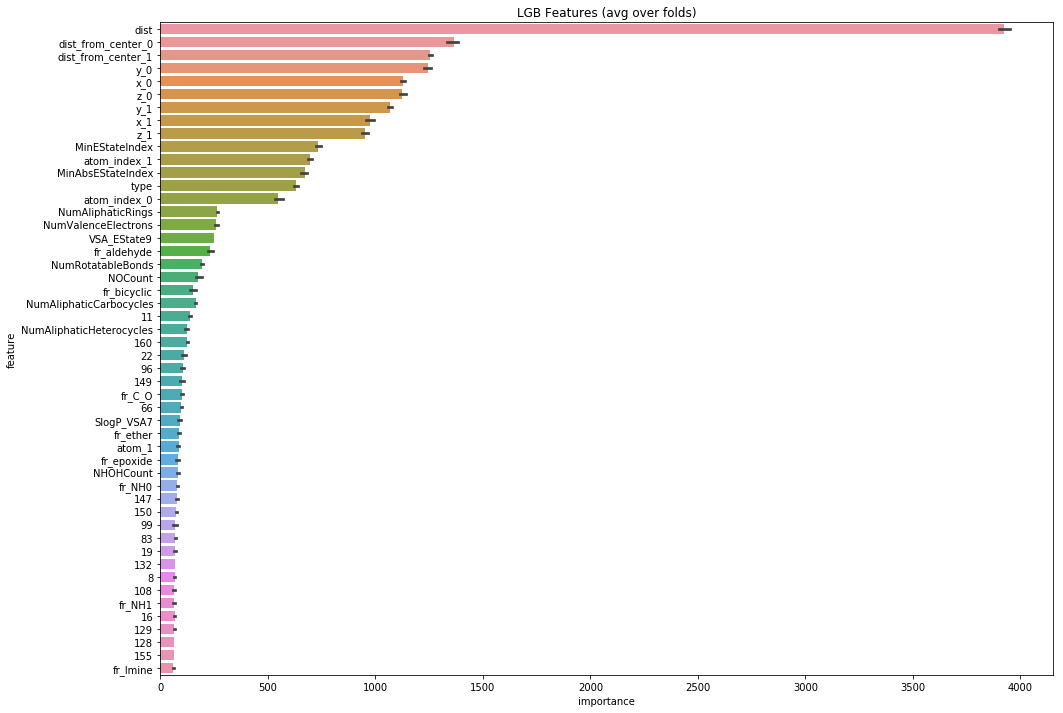

![](http://)

In [6]:
#blocking
#drop_mol =mol_high_std.drop(["102", "107","134","112", "117","119","122", "148","124","130", "143","162", "76",
#                 "NumAromaticHeterocycles","NumAromaticRings","NumHAcceptors","NumHeteroatoms", "NumHDonors",
#                 "NumSaturatedCarbocycles","NumSaturatedHeterocycles", "NumSaturatedRings","RingCount","
#                 "fr_C_O_noCOO","fr_NH2", "fr_Nhpyrrole","fr_nitrile", 
#                 "fr_oxime"] , axis=1)

#fr_COO", "fr_COO2","NumAromaticCarbocycles","fr_nitro","fr_nitro_arom_nonortho",, "fr_phenol_noOrthoHbond"

In [7]:
#omit high bias varibles
#drop_mol=drop_mol.drop(["166","15","125","21","23","24","25","26","28","42","45","49","56","63","87",
#                        "fr_Al_OH","fr_Ar_COO","fr_HOCCN","fr_alkyl_carbamate","fr_alkyl_halide",
#                        "fr_azo","fr_diazo","fr_dihydropyridine","fr_furan","fr_guanido","fr_hdrzone","fr_imidazole",
#                        "fr_imide","fr_lactam","fr_morpholine","fr_nitro_arom","fr_nitroso","fr_oxazole","fr_para_hydroxylation",
#                        "fr_phenol","fr_piperzine","fr_pyridine","fr_quatN","fr_tetrazole","fr_unbrch_alkane","fr_urea"], 
#                       axis=1)

In [8]:
#Choose top 20 parameters
drop_mol=mol_dataset.loc[:, ["MinEStateIndex",
                     "MinAbsEStateIndex",
                     "NumAliphaticRings",
                     "NumValenceElectrons",
                     "VSA_EState9",
                     "fr_aldehyde",
                     "NumRotatableBonds",
                     "NOCount",
                     "fr_bicyclic",
                     "NumAliphaticCarbocycles",
                     "11",
                     "NumAliphaticHeterocycles",
                     "160",
                     "22",
                     "96",
                     "149",
                     "fr_C_O",
                     "66",
                     "SlogP_VSA7",
                     "fr_ether"]]

In [9]:
drop_mol.head()

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0
1,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
2,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
3,3.5,3.5,0,10,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0
4,2.0,2.0,0,14,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,0


OK, now 367 comlums become only 135 columns after rough pre-processing.

In [10]:
#marge
drop_mol["molecule_name"]=mol_name
drop_mol.head(5)

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether,molecule_name
0,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0,dsgdb9nsd_000001
1,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000002
2,0.0,0.0,0,8,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000003
3,3.5,3.5,0,10,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000005
4,2.0,2.0,0,14,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,0,dsgdb9nsd_000007


In [11]:
#devide dataset
train_mol = drop_mol[0:85003]
test_mol = drop_mol[85003:130776]
test_mol.head(5)

,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether,molecule_name
85003,4.000000,4.000000,0,10,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,dsgdb9nsd_000004
85004,1.625000,1.625000,0,20,3.25,0,0,1,0,0,0,0,1,0,0,1,0,0,0.0,1,dsgdb9nsd_000015
85005,1.500000,1.500000,1,18,0.00,0,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0,dsgdb9nsd_000016
85006,-0.833496,0.833496,0,24,0.00,0,0,3,0,0,0,0,0,0,0,0,1,0,0.0,0,dsgdb9nsd_000020
85007,-0.166626,0.166626,0,26,0.00,0,0,1,0,0,0,0,1,0,0,1,0,0,0.0,0,dsgdb9nsd_000022


In [12]:
#prepare dataset for modeling
#Load data
train = pd.read_csv("../input/champs-scalar-coupling/train.csv")
test = pd.read_csv("../input/champs-scalar-coupling/test.csv")

#Load sub data
sub = pd.read_csv("../input/champs-scalar-coupling/sample_submission.csv")
structures = pd.read_csv("../input/champs-scalar-coupling/structures.csv")

In [13]:
#def map_atom_info(df, atom_idx):
#    df = pd.merge(df, structures, how = 'left',
#                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
#                  right_on = ['molecule_name',  'atom_index'])
    
#    df = df.drop('atom_index', axis=1)
#    df = df.rename(columns={'atom': f'atom_{atom_idx}',
#                            'x': f'x_{atom_idx}',
#                            'y': f'y_{atom_idx}',
#                            'z': f'z_{atom_idx}'})
    #structures['c_x'] = structures.groupby('molecule_name')['x'].transform('mean')
    #structures['c_y'] = structures.groupby('molecule_name')['y'].transform('mean')
    #structures['c_z'] = structures.groupby('molecule_name')['z'].transform('mean')
#    return df

In [14]:
#train_structure = map_atom_info(train, 0)
#train_structure = map_atom_info(train_structure, 1)
#test_structure = map_atom_info(test, 0)
#test_structure = map_atom_info(test_structure, 1)

#train_structure.head(5)

In [15]:
def map_atom_info(df_1, df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    return df

def get_features(df, struct):
    for atom_idx in [0,1]:
        df = map_atom_info(df, struct, atom_idx)
        df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
        struct['c_x'] = struct.groupby('molecule_name')['x'].transform('mean')
        struct['c_y'] = struct.groupby('molecule_name')['y'].transform('mean')
        struct['c_z'] = struct.groupby('molecule_name')['z'].transform('mean')

   # df = find_dist(df)
   # df = find_closest_atom(df)
   # df = add_cos_features(df)
   # df = add_dist_features(df)
   # df = add_qm9_features(df)
    
    return df

In [16]:
train_structure = get_features(train, structures.copy())
test_structure = get_features(test, structures.copy())

train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001


In [17]:
train_p_0 = train_structure[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_structure[['x_1', 'y_1', 'z_1']].values
train_structure['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
train_structure['dist_x'] = (train_structure['x_0'] - train_structure['x_1']) ** 2
train_structure['dist_y'] = (train_structure['y_0'] - train_structure['y_1']) ** 2
train_structure['dist_z'] = (train_structure['z_0'] - train_structure['z_1']) ** 2
train_structure['dist_from_center_0'] = np.linalg.norm(train_p_0, axis=1)
train_structure['dist_from_center_1'] = np.linalg.norm(train_p_1, axis=1)

test_p_0 = test_structure[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_structure[['x_1', 'y_1', 'z_1']].values
test_structure['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
test_structure['dist_x'] = (test_structure['x_0'] - test_structure['x_1']) ** 2
test_structure['dist_y'] = (test_structure['y_0'] - test_structure['y_1']) ** 2
test_structure['dist_z'] = (test_structure['z_0'] - test_structure['z_1']) ** 2
test_structure['dist_from_center_0'] = np.linalg.norm(test_p_0, axis=1)
test_structure['dist_from_center_1'] = np.linalg.norm(test_p_1, axis=1)

In [18]:
train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091953,0.000220,1.192105,0.000036,0.006701,1.085908
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001,1.783120,1.019253,2.160261,0.000003,0.006701,1.779373
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001,1.783147,0.294812,2.112831,0.771973,0.006701,1.776603
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001,1.783157,0.276638,2.085032,0.817978,0.006701,1.778648
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091952,1.049455,0.142844,0.000060,1.779373,1.085908


#Add more featutes using by Feature generation funcs  
Reference:https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28  

First the type is encoded by a label encoder.  
The merging template and selected features from Andrew's brute force feature engineering  
Cosine features originally from Effective feature and expanded in Keras Neural Net for CHAMPS, I simplified the generation procedure by  removing unnecessary pandas operations since vanilla numpy arrays operation is faster.  
QM9 dataset from Quantum Machine 9 - QM9.  
Parallelization computed Yukawa potentials.  
Giba's features from Giba R + data.table + Simple Features, which I now export the features to a dataset: Giba molecular features.  

In [19]:
def find_closest_atom(df):    
    df_temp = df.loc[:,["molecule_name",
                      "atom_index_0","atom_index_1",
                      "dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_ = df_temp.copy()
    df_temp_ = df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all = pd.concat((df_temp,df_temp_),axis=0)

    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('max')
    
    df_temp = df_temp_all[df_temp_all["min_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp = df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'dist': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
    
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
        
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'dist': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
        
    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df

In [20]:
train_structure = find_closest_atom(train_structure)
test_structure = find_closest_atom(test_structure)

train_structure.head(5)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091953,0.000220,1.192105,0.000036,0.006701,1.085908,0,1.091953,-0.012698,1.085804,0.008001,1.783157,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,4,1.783157,-0.523814,1.437933,0.906397,1.091953,1,1.091953,0.002150,-0.006031,0.001976,1.091946
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001,1.783120,1.019253,2.160261,0.000003,0.006701,1.779373,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091952,-0.012698,1.085804,0.008001,1.783158,4,1.783157,-0.523814,1.437933,0.906397,1.091953,3,1.783158,-0.540815,1.447527,-0.876644,1.091952
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001,1.783147,0.294812,2.112831,0.771973,0.006701,1.776603,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091946,-0.012698,1.085804,0.008001,1.783158,4,1.783157,-0.523814,1.437933,0.906397,1.091953,2,1.783158,1.011731,1.463751,0.000277,1.091946
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001,1.783157,0.276638,2.085032,0.817978,0.006701,1.778648,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091948,-0.012698,1.085804,0.008001,1.783157,4,1.783157,-0.523814,1.437933,0.906397,1.091953,1,1.783157,0.002150,-0.006031,0.001976,1.091948
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091952,1.049455,0.142844,0.000060,1.779373,1.085908,0,1.091952,-0.012698,1.085804,0.008001,1.783158,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,3,1.783158,-0.540815,1.447527,-0.876644,1.091952,1,1.091953,0.002150,-0.006031,0.001976,1.091946


In [21]:
def add_cos_features(df):
    
    df["distance_center0"] = np.sqrt((df['x_0']-df['c_x'])**2 \
                                   + (df['y_0']-df['c_y'])**2 \
                                   + (df['z_0']-df['c_z'])**2)
    df["distance_center1"] = np.sqrt((df['x_1']-df['c_x'])**2 \
                                   + (df['y_1']-df['c_y'])**2 \
                                   + (df['z_1']-df['c_z'])**2)
    
    df['distance_c0'] = np.sqrt((df['x_0']-df['x_closest_0'])**2 + \
                                (df['y_0']-df['y_closest_0'])**2 + \
                                (df['z_0']-df['z_closest_0'])**2)
    df['distance_c1'] = np.sqrt((df['x_1']-df['x_closest_1'])**2 + \
                                (df['y_1']-df['y_closest_1'])**2 + \
                                (df['z_1']-df['z_closest_1'])**2)
    
    df["distance_f0"] = np.sqrt((df['x_0']-df['x_farthest_0'])**2 + \
                                (df['y_0']-df['y_farthest_0'])**2 + \
                                (df['z_0']-df['z_farthest_0'])**2)
    df["distance_f1"] = np.sqrt((df['x_1']-df['x_farthest_1'])**2 + \
                                (df['y_1']-df['y_farthest_1'])**2 + \
                                (df['z_1']-df['z_farthest_1'])**2)
    
    vec_center0_x = (df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    vec_center0_y = (df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    vec_center0_z = (df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    
    vec_center1_x = (df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    vec_center1_y = (df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    vec_center1_z = (df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    
    vec_c0_x = (df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_y = (df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_z = (df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    
    vec_c1_x = (df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_y = (df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_z = (df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    
    vec_f0_x = (df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_y = (df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_z = (df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    
    vec_f1_x = (df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_y = (df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_z = (df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    
    vec_x = (df['x_1']-df['x_0'])/df['dist']
    vec_y = (df['y_1']-df['y_0'])/df['dist']
    vec_z = (df['z_1']-df['z_0'])/df['dist']
    
    df["cos_c0_c1"] = vec_c0_x*vec_c1_x + vec_c0_y*vec_c1_y + vec_c0_z*vec_c1_z
    df["cos_f0_f1"] = vec_f0_x*vec_f1_x + vec_f0_y*vec_f1_y + vec_f0_z*vec_f1_z
    
    df["cos_c0_f0"] = vec_c0_x*vec_f0_x + vec_c0_y*vec_f0_y + vec_c0_z*vec_f0_z
    df["cos_c1_f1"] = vec_c1_x*vec_f1_x + vec_c1_y*vec_f1_y + vec_c1_z*vec_f1_z
    
    df["cos_center0_center1"] = vec_center0_x*vec_center1_x \
                              + vec_center0_y*vec_center1_y \
                              + vec_center0_z*vec_center1_z
    
    df["cos_c0"] = vec_c0_x*vec_x + vec_c0_y*vec_y + vec_c0_z*vec_z
    df["cos_c1"] = vec_c1_x*vec_x + vec_c1_y*vec_y + vec_c1_z*vec_z
    
    df["cos_f0"] = vec_f0_x*vec_x + vec_f0_y*vec_y + vec_f0_z*vec_z
    df["cos_f1"] = vec_f1_x*vec_x + vec_f1_y*vec_y + vec_f1_z*vec_z
    
    df["cos_center0"] = vec_center0_x*vec_x + vec_center0_y*vec_y + vec_center0_z*vec_z
    df["cos_center1"] = vec_center1_x*vec_x + vec_center1_y*vec_y + vec_center1_z*vec_z

    return df

In [22]:
train_structure = add_cos_features(train_structure)
test_structure = add_cos_features(test_structure)

train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,x_farthest_1,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_c0_f0,cos_c1_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091953,0.000220,1.192105,0.000036,0.006701,1.085908,0,1.091953,-0.012698,1.085804,0.008001,1.783157,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,4,1.783157,-0.523814,1.437933,0.906397,1.091953,1,1.091953,0.002150,-0.006031,0.001976,1.091946,1.091945,0.000012,1.091953,1.091946,1.783157,1.091953,0.333335,-0.816502,0.816502,-0.333335,-0.649313,-1.000000,-0.333335,-0.816502,1.000000,-1.000000,0.649319
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,-0.012689,1.085797,0.008001,1.783120,1.019253,2.160261,0.000003,0.006701,1.779373,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091952,-0.012698,1.085804,0.008001,1.783158,4,1.783157,-0.523814,1.437933,0.906397,1.091953,3,1.783158,-0.540815,1.447527,-0.876644,1.091952,1.091945,1.091946,1.091953,1.091952,1.783157,1.783158,-0.333287,0.000016,0.816502,0.816503,-0.333304,-0.816483,0.816482,-0.499994,0.499995,-0.816487,0.816488
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,-0.012689,1.085797,0.008001,1.783147,0.294812,2.112831,0.771973,0.006701,1.776603,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091946,-0.012698,1.085804,0.008001,1.783158,4,1.783157,-0.523814,1.437933,0.906397,1.091953,2,1.783158,1.011731,1.463751,0.000277,1.091946,1.091945,1.091954,1.091953,1.091946,1.783157,1.783158,-0.333335,-0.000016,0.816502,0.816501,-0.333335,-0.816498,0.816496,-0.500002,0.500018,-0.816496,0.816499
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,-0.012689,1.085797,0.008001,1.783157,0.276638,2.085032,0.817978,0.006701,1.778648,0,1.091953,-0.012698,1.085804,0.008001,1.783157,0,1.091948,-0.012698,1.085804,0.008001,1.783157,4,1.783157,-0.523814,1.437933,0.906397,1.091953,1,1.783157,0.002150,-0.006031,0.001976,1.091948,1.091945,1.091954,1.091953,1.091948,1.783157,1.783157,-0.333347,-1.000000,0.816502,0.816500,-0.333349,-0.816502,0.816500,-1.000000,1.000000,-0.816500,0.816503
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,-0.012689,1.085797,0.008001,1.091952,1.049455,0.142844,0.000060,1.779373,1.085908,0,1.091952,-0.012698,1.085804,0.008001,1.783158,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,3,1.783158,-0.540815,1.447527,-0.876644,1.091952,1,1.091953,0.002150,-0.006031,0.001976,1.091946,1.091946,0.000012,1.091952,1.091946,1.783158,1.091953,0.333352,-0.000028,0.816503,-0.333335,-0.499068,-1.000000,-0.333352,-0.816503,-0.333287,-1.000000,0.499076


In [23]:
#merge data
train_merged = pd.merge(train_structure, train_mol, how="inner", on ="molecule_name")
#train_merged.head(5)
test_merged = pd.merge(test_structure, test_mol, how="inner", on ="molecule_name")
test_merged.head(5)


,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,...,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_c0_f0,cos_c1_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.661639,0.0,1.0,C,0.599539,0.0,1.0,0.0,0.0,1.0,2.261178,5.112926,0.0,0.0,1.939341,1.165954,1,1.062099,-0.599539,0.0,1.0,3.323277,3,1.062099,1.661639,0.0,1.0,2.261178,3,3.323277,1.661639,0.0,1.0,1.062099,...,0.0,1.0,1.062099,1.661639,0.599539,1.062099,1.062099,3.323277,2.261178,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.661639,0.0,1.0,C,-0.599539,0.0,1.0,0.0,0.0,1.0,1.062099,1.128054,0.0,0.0,1.939341,1.165954,1,1.062099,-0.599539,0.0,1.0,3.323277,2,1.062099,-1.661639,0.0,1.0,2.261178,3,3.323277,1.661639,0.0,1.0,1.062099,...,0.0,1.0,1.062099,1.661639,0.599539,1.062099,1.062099,3.323277,2.261178,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.661639,0.0,1.0,H,1.661639,0.0,1.0,0.0,0.0,1.0,3.323277,11.044171,0.0,0.0,1.939341,1.939341,1,1.062099,-0.599539,0.0,1.0,3.323277,0,1.062099,0.599539,0.0,1.0,3.323277,3,3.323277,1.661639,0.0,1.0,1.062099,...,0.0,1.0,1.062099,1.661639,1.661639,1.062099,1.062099,3.323277,3.323277,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.661639,0.0,1.0,C,0.599539,0.0,1.0,0.0,0.0,1.0,1.062099,1.128054,0.0,0.0,1.939341,1.165954,0,1.062099,0.599539,0.0,1.0,3.323277,3,1.062099,1.661639,0.0,1.0,2.261178,2,3.323277,-1.661639,0.0,1.0,1.062099,...,0.0,1.0,1.062099,1.661639,0.599539,1.062099,1.062099,3.323277,2.261178,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.661639,0.0,1.0,C,-0.599539,0.0,1.0,0.0,0.0,1.0,2.261178,5.112926,0.0,0.0,1.939341,1.165954,0,1.062099,0.599539,0.0,1.0,3.323277,2,1.062099,-1.661639,0.0,1.0,2.261178,2,3.323277,-1.661639,0.0,1.0,1.062099,...,0.0,1.0,1.062099,1.661639,0.599539,1.062099,1.062099,3.323277,2.261178,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0


In [24]:
test_merged.shape

(2505542, 83)

In [25]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import time
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import gc
import warnings
warnings.filterwarnings("ignore")

In [26]:
#Prepare dataset
# Label Encoding
for f in ['atom_0', 'atom_1']:#,'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train_merged[f].values) + list(test_merged[f].values))
    train_merged[f] = lbl.transform(list(train_merged[f].values))
    test_merged[f] = lbl.transform(list(test_merged[f].values))

#If folloing code add above for-loop "lbl.inverse_transform([1])[0]" will fail to re-labeling
lbl = LabelEncoder()
lbl.fit(list(train_merged['type'].values) + list(test_merged['type'].values))
train_merged['type'] = lbl.transform(list(train_merged['type'].values))
test_merged['type'] = lbl.transform(list(test_merged['type'].values))

In [27]:
test_merged.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,...,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_c0_f0,cos_c1_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,4658147,dsgdb9nsd_000004,2,0,2,0,-1.661638586,0.0,1.0,0,0.5995394918,0.0,1.0,0.0,0.0,1.0,2.2611780778,5.112926299523302,0.0,0.0,1.939340813391004,1.165953516323786,1,1.0620990942,-0.5995394918,0.0,1.0,3.323277172,3,1.0620990942,1.6616385860,0.0,1.0,2.2611780778,3,3.323277172,1.661638586,0.0,1.0,1.0620990942,...,0.0,1.0,1.0620990942,1.661638586,0.5995394918,1.0620990942,1.0620990942,3.323277172,2.2611780778,0.999999999811694,-0.999999999925684,0.999999999875756,-0.999999999861622,-0.999999999773024,-0.999999999905847,-0.999999999905847,-0.999999999969909,0.999999999955775,-0.999999999939818,0.999999999833205,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
1,4658148,dsgdb9nsd_000004,2,1,0,0,-1.661638586,0.0,1.0,0,-0.5995394918,0.0,1.0,0.0,0.0,1.0,1.0620990942,1.128054485900461,0.0,0.0,1.939340813391004,1.165953516323786,1,1.0620990942,-0.5995394918,0.0,1.0,3.323277172,2,1.0620990942,-1.6616385860,0.0,1.0,2.2611780778,3,3.323277172,1.661638586,0.0,1.0,1.0620990942,...,0.0,1.0,1.0620990942,1.661638586,0.5995394918,1.0620990942,1.0620990942,3.323277172,2.2611780778,-0.999999999811694,0.999999999925684,0.999999999875756,-0.999999999861622,0.999999999773024,-0.999999999905847,0.999999999905847,-0.999999999969909,-0.999999999955775,-0.999999999939818,-0.999999999833205,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
2,4658149,dsgdb9nsd_000004,2,3,6,0,-1.661638586,0.0,1.0,1,1.6616385860,0.0,1.0,0.0,0.0,1.0,3.3232771720,11.044171161936317,0.0,0.0,1.939340813391004,1.939340813391004,1,1.0620990942,-0.5995394918,0.0,1.0,3.323277172,0,1.0620990942,0.5995394918,0.0,1.0,3.3232771720,3,3.323277172,1.661638586,0.0,1.0,1.0620990942,...,0.0,1.0,1.0620990942,1.661638586,1.6616385860,1.0620990942,1.0620990942,3.323277172,3.3232771720,-0.999999999811694,-0.999999999939818,0.999999999875756,0.999999999875756,-0.999999999879637,-0.999999999905847,0.999999999905847,-0.999999999969909,0.999999999969909,-0.999999999939818,0.999999999939818,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
3,4658150,dsgdb9nsd_000004,3,0,0,0,1.661638586,0.0,1.0,0,0.5995394918,0.0,1.0,0.0,0.0,1.0,1.0620990942,1.128054485900461,0.0,0.0,1.939340813391004,1.165953516323786,0,1.0620990942,0.5995394918,0.0,1.0,3.323277172,3,1.0620990942,1.6616385860,0.0,1.0,2.2611780778,2,3.323277172,-1.661638586,0.0,1.0,1.0620990942,...,0.0,1.0,1.0620990942,1.661638586,0.5995394918,1.0620990942,1.0620990942,3.323277172,2.2611780778,-0.999999999811694,0.999999999925684,0.999999999875756,-0.999999999861622,0.999999999773024,-0.999999999905847,0.999999999905847,-0.999999999969909,-0.999999999955775,-0.999999999939818,-0.999999999833205,4.0,4.0,0,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0
4,4658151,dsgdb9nsd_000004,3,1,2,0,1.661638586,0.0,1.0,0,-0.5995394918,0.0,1.0,0.0,0.0,1.0,2.2611780778,5.112926299523302,0.0,0.0,1.939340813391004,1.165953516323786,0,1.0620990942,0.5995394918,0.0,1.0,3.323277172,2,1.0620990942,-1.6616385860,0.0,1.0,2.2611780778,2,3.323277172,-1.661638586,0.0,1.0,1.0620990942,...,0.0,1.0,1.0620990942,1.661638586,0.5995394918,1.0620990942,1.0620990942,3.323277172,2.2611780778,0.99999999981

In [28]:
train_merged = reduce_mem_usage(train_merged)
test_merged = reduce_mem_usage(test_merged)

Mem. usage decreased to 706.33 Mb (70.8% reduction)
Mem. usage decreased to 375.15 Mb (70.7% reduction)


In [29]:
def del_cols(df, cols):
    del_cols_list_ = [l for l in cols if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

y_train = train_merged.scalar_coupling_constant
x_train = del_cols(train_merged, ["molecule_name", "scalar_coupling_constant", "id"])
x_test = del_cols(test_merged, ["molecule_name", "id"])
x_train.head(5)

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,c_x,c_y,c_z,dist,dist_x,dist_y,dist_z,dist_from_center_0,dist_from_center_1,atom_index_closest_0,distance_closest_0,x_closest_0,y_closest_0,z_closest_0,max_distance_x,atom_index_closest_1,distance_closest_1,x_closest_1,y_closest_1,z_closest_1,max_distance_y,atom_index_farthest_0,distance_farthest_0,x_farthest_0,y_farthest_0,z_farthest_0,min_distance_x,atom_index_farthest_1,distance_farthest_1,...,y_farthest_1,z_farthest_1,min_distance_y,distance_center0,distance_center1,distance_c0,distance_c1,distance_f0,distance_f1,cos_c0_c1,cos_f0_f1,cos_c0_f0,cos_c1_f1,cos_center0_center1,cos_c0,cos_c1,cos_f0,cos_f1,cos_center0,cos_center1,MinEStateIndex,MinAbsEStateIndex,NumAliphaticRings,NumValenceElectrons,VSA_EState9,fr_aldehyde,NumRotatableBonds,NOCount,fr_bicyclic,NumAliphaticCarbocycles,11,NumAliphaticHeterocycles,160,22,96,149,fr_C_O,66,SlogP_VSA7,fr_ether
0,1,0,0,0,0.00214958190918,-0.006031036376953,0.001976013183594,0,-0.01269531250,1.0859375000,0.008003234863281,-0.012687683105469,1.0859375,0.008003234863281,1.091796875,0.000220537185669,1.192382812500,0.000036299228668,0.006702423095703,1.0859375000,0,1.091796875,-0.0126953125,1.0859375,0.008003234863281,1.783203125,3,1.091796875,-0.5410156250,1.447265625,-0.876464843750000,1.091796875,4,1.783203125,-0.52392578125,1.437500000,0.90625000000,1.091796875,1,1.091796875,...,-0.006031036376953,0.001976013183594,1.091796875,1.091796875,0.000011742115021,1.091796875,1.091796875,1.783203125,1.091796875,0.333251953125,-0.816406250000000,0.81640625,-0.333251953125,-0.649414062500,-1.00000000,-0.333251953125,-0.81640625,1.000000000000,-1.00000000,0.6494140625,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0
1,1,2,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,1.01171875000,1.4638671875,0.000276565551758,-0.012687683105469,1.0859375,0.008003234863281,1.783203125,1.019531250000000,2.160156250000,0.000002861022949,0.006702423095703,1.7792968750,0,1.091796875,-0.0126953125,1.0859375,0.008003234863281,1.783203125,0,1.091796875,-0.0126953125,1.085937500,0.008003234863281,1.783203125,4,1.783203125,-0.52392578125,1.437500000,0.90625000000,1.091796875,3,1.783203125,...,1.447265625000000,-0.876464843750000,1.091796875,1.091796875,1.091796875000000,1.091796875,1.091796875,1.783203125,1.783203125,-0.333251953125,0.000015854835510,0.81640625,0.816406250000,-0.333251953125,-0.81640625,0.816406250000,-0.50000000,0.500000000000,-0.81640625,0.8164062500,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0
2,1,3,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,-0.54101562500,1.4472656250,-0.876464843750000,-0.012687683105469,1.0859375,0.008003234863281,1.783203125,0.294921875000000,2.113281250000,0.771972656250000,0.006702423095703,1.7763671875,0,1.091796875,-0.0126953125,1.0859375,0.008003234863281,1.783203125,0,1.091796875,-0.0126953125,1.085937500,0.008003234863281,1.783203125,4,1.783203125,-0.52392578125,1.437500000,0.90625000000,1.091796875,2,1.783203125,...,1.463867187500000,0.000276565551758,1.091796875,1.091796875,1.091796875000000,1.091796875,1.091796875,1.783203125,1.783203125,-0.333251953125,-0.000015854835510,0.81640625,0.816406250000,-0.333251953125,-0.81640625,0.816406250000,-0.50000000,0.500000000000,-0.81640625,0.8164062500,0.0,0.0,0,8,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0
3,1,4,3,0,0.00214958190918,-0.006031036376953,0.001976013183594,1,-0.52392578125,1.4375000000,0.906250000000000,-0.012687683105469,1.0859375,0.008003234863281,1.783203125,0.276611328125000,2.085937500000,0.817871093750000,0.006702423095703,1.7783203125,0,1.091796875,-0.0126953125,1.0859375,0.008003234863281,1.783203125,0,1.091796875,-0.0126953125,1.085937500,0.008003234863281,1.783203125,4,1.783203125,-0.52392578125,1.437500000,0.90625000000,1.091796875,1,1.783203125,...,-0.006031036376953,0.001976013183594,1.091796875,1.091796875,1.091796875000000,1.091796875,1.091796875,1.783203125,1.783203125,-0.333251953125,-1.000000000000000,0.81640

In [30]:
#test_merged['type'].unique()
#lbl.inverse_transform([1])[0]

#Build model and Run

In [31]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [32]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [33]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [34]:
#Set hyper parameters
params = {'num_leaves': 200,
          #'min_child_samples': 32,
          'objective': 'regression',  #I will check it.
          'max_depth': 9,
          'learning_rate': 0.08,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.8,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          #'reg_alpha': 0.8,
          #'reg_lambda': 0.2,
          #'colsample_bytree': 0.6
          'lambda_l1': 0.8,
          'lambda_l2': 0.2,
          'feature_fraction': 0.6,
         }

#Training by type with time seed  
Type 0 = 1JHC. 
Type 1 = 1JHN. 
Type 2 = 2JHC. 
Type 3 = 2JHH. 
Type 4 = 2JHN. 
Type 5 = 3JHC. 
Type 6 = 3JHH. 
Type 7 = 3JHN. 

Reference:  
https://www.kaggle.com/scaomath/no-memory-reduction-workflow-for-each-type-lb-1-28

In [35]:
#We use different numbers of iterations for different type, after running the label encoder
###Iters###    [1JHC, 1JHN, 2JHC, 2JHH, 2JHN, 3JHC, 3JHH, 3JHN]
n_estimators = [10000, 4000, 4000, 2500, 2500, 4000, 2500, 2500]

In [36]:
#test_merged['type'].unique()
#train_structure['atom_1'].describe()

In [37]:
X_short = pd.DataFrame({'ind': list(train_merged.index), 
                        'type': train_merged['type'].values,
                        'oof': [0] * len(train_merged), 
                        'target': y_train.values})
X_short_test = pd.DataFrame({'ind': list(test_merged.index), 
                             'type': test_merged['type'].values, 
                             'prediction': [0] * len(test_merged)})

In [38]:
#lbl.inverse_transform([7])[0]


Training of type 0: 1JHC.
Fold 1 started at Tue Jul 23 13:49:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.75569	valid_1's l1: 1.99264
[1000]	training's l1: 1.42804	valid_1's l1: 1.81701
[1500]	training's l1: 1.22681	valid_1's l1: 1.73869
[2000]	training's l1: 1.07281	valid_1's l1: 1.68669
[2500]	training's l1: 0.95081	valid_1's l1: 1.65244
[3000]	training's l1: 0.848824	valid_1's l1: 1.62715
[3500]	training's l1: 0.763619	valid_1's l1: 1.60742
[4000]	training's l1: 0.690335	valid_1's l1: 1.59186
[4500]	training's l1: 0.627029	valid_1's l1: 1.57913
[5000]	training's l1: 0.57124	valid_1's l1: 1.56896
[5500]	training's l1: 0.522275	valid_1's l1: 1.56069
[6000]	training's l1: 0.478188	valid_1's l1: 1.55354
[6500]	training's l1: 0.438914	valid_1's l1: 1.54771
[7000]	training's l1: 0.403751	valid_1's l1: 1.54267
[7500]	training's l1: 0.372017	valid_1's l1: 1.53833
[8000]	training's l1: 0.34345	valid_1's l1: 1.5345
[8500]	training's l1: 0.3177

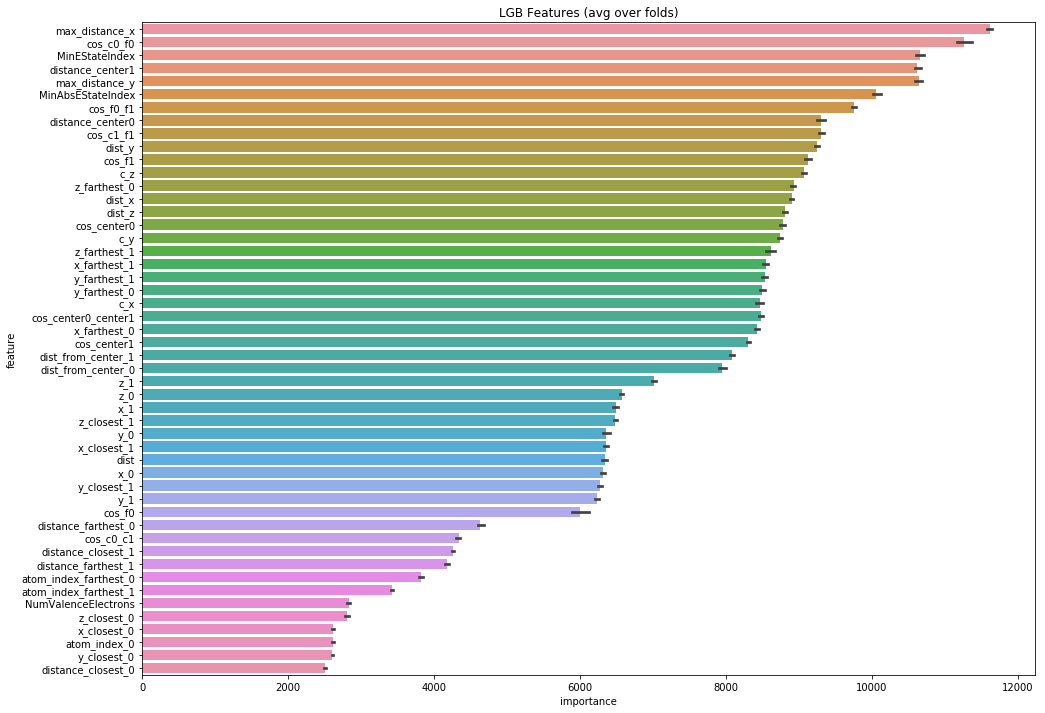

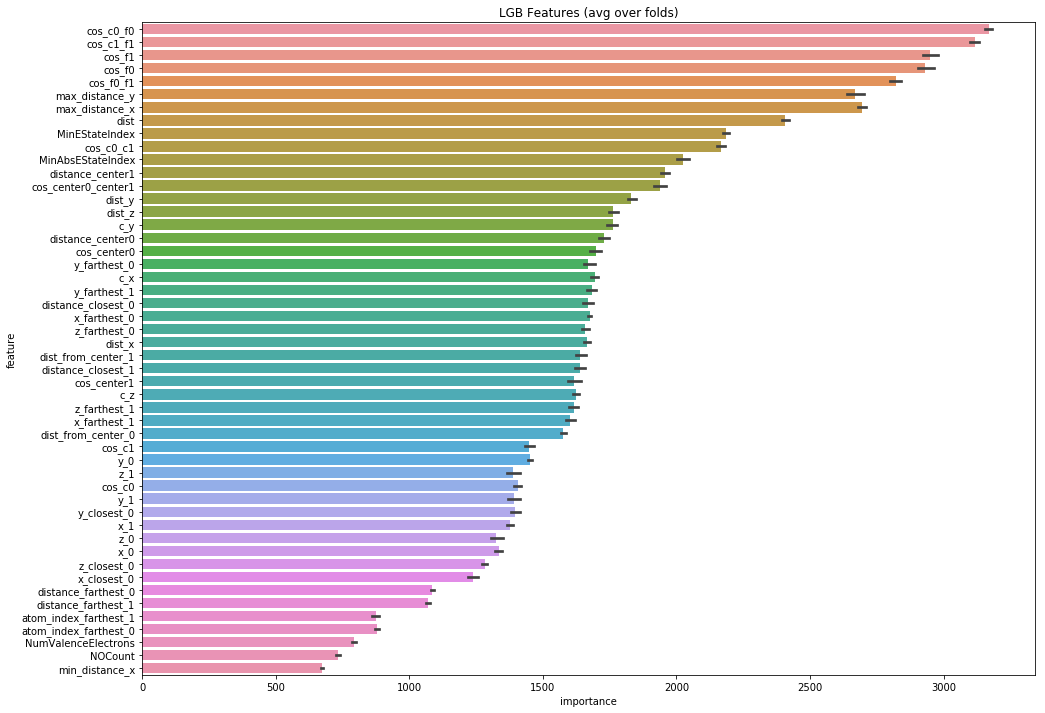

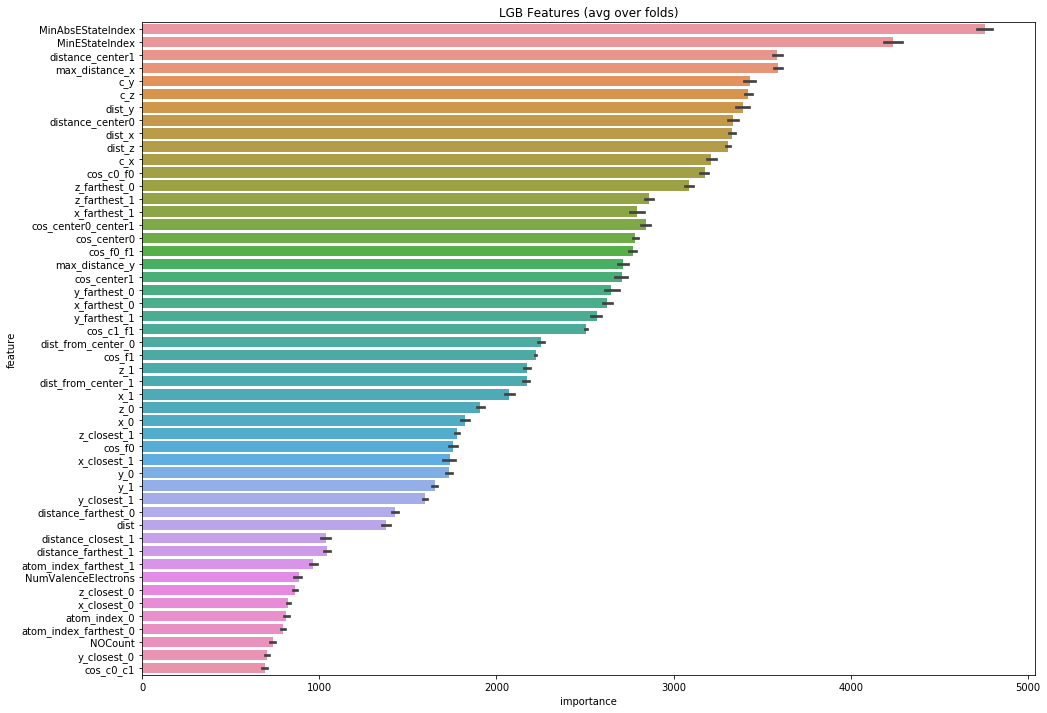

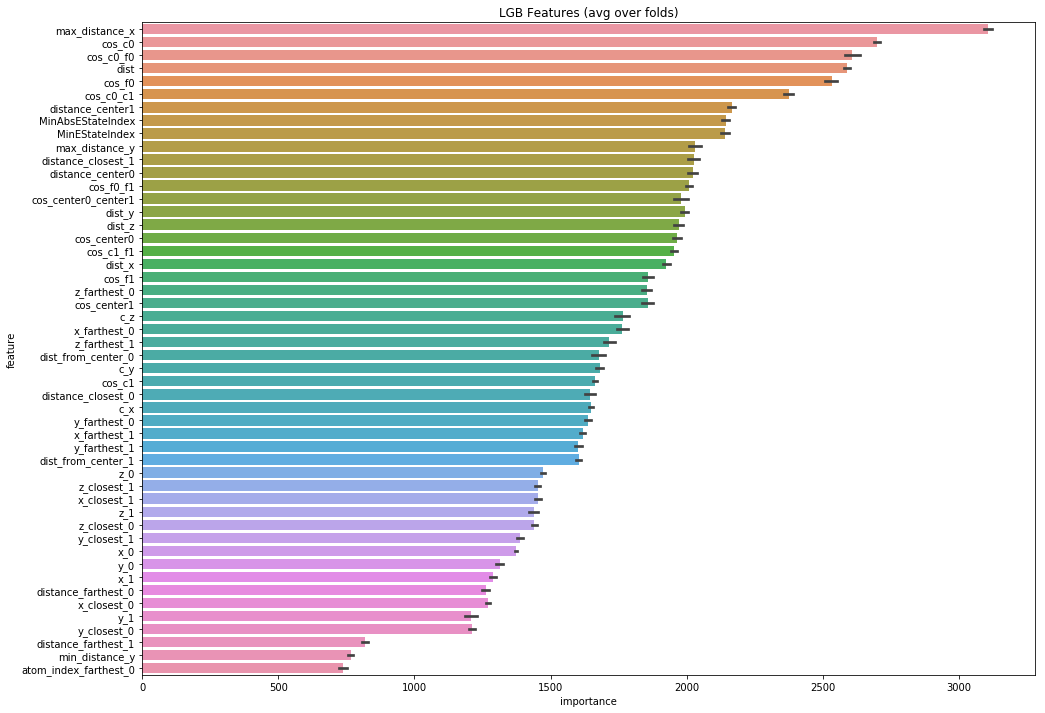

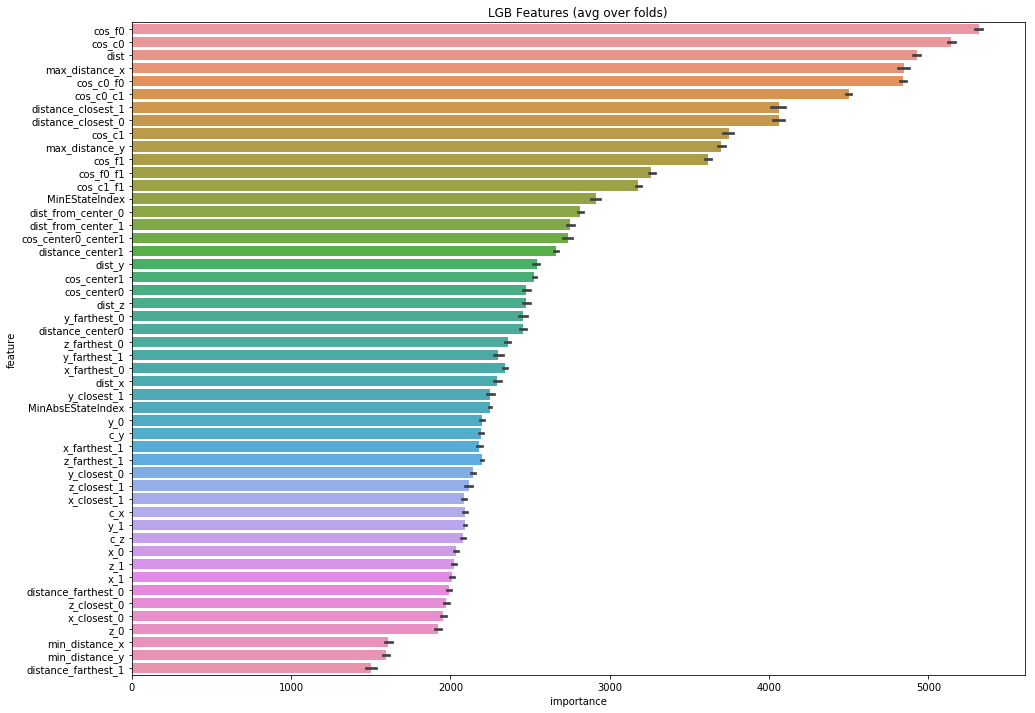

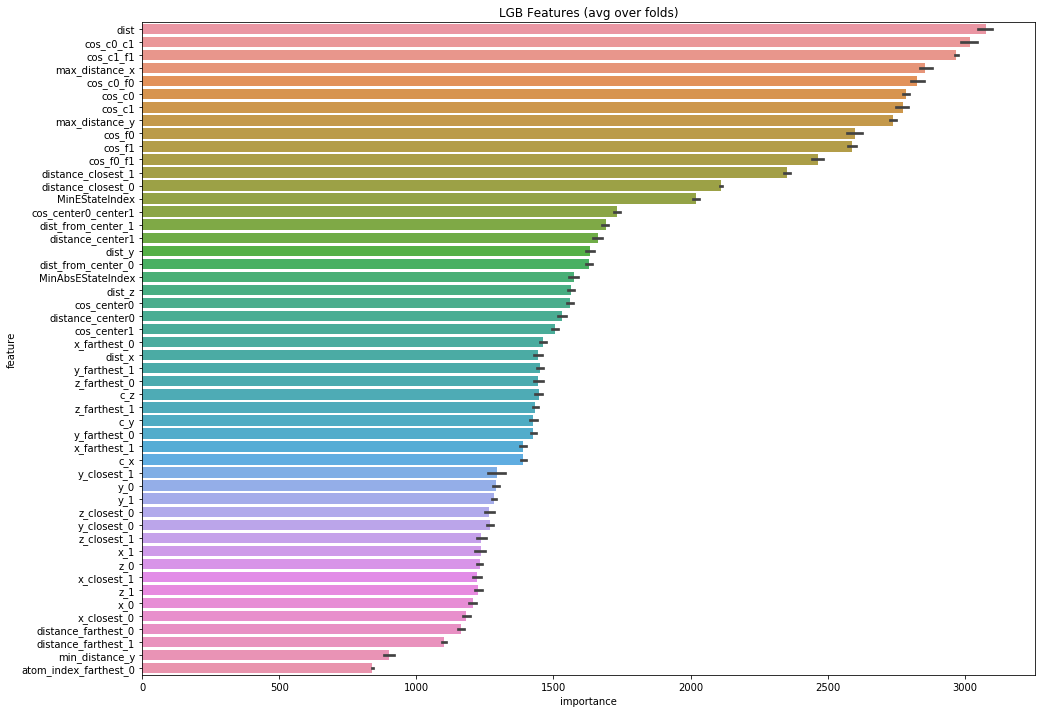

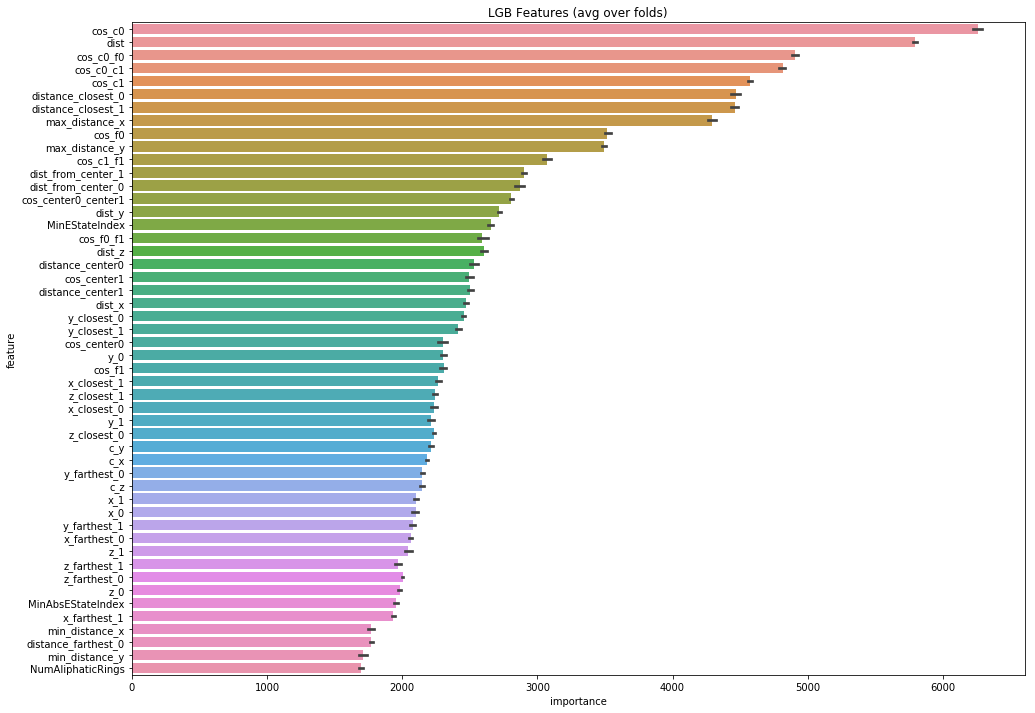

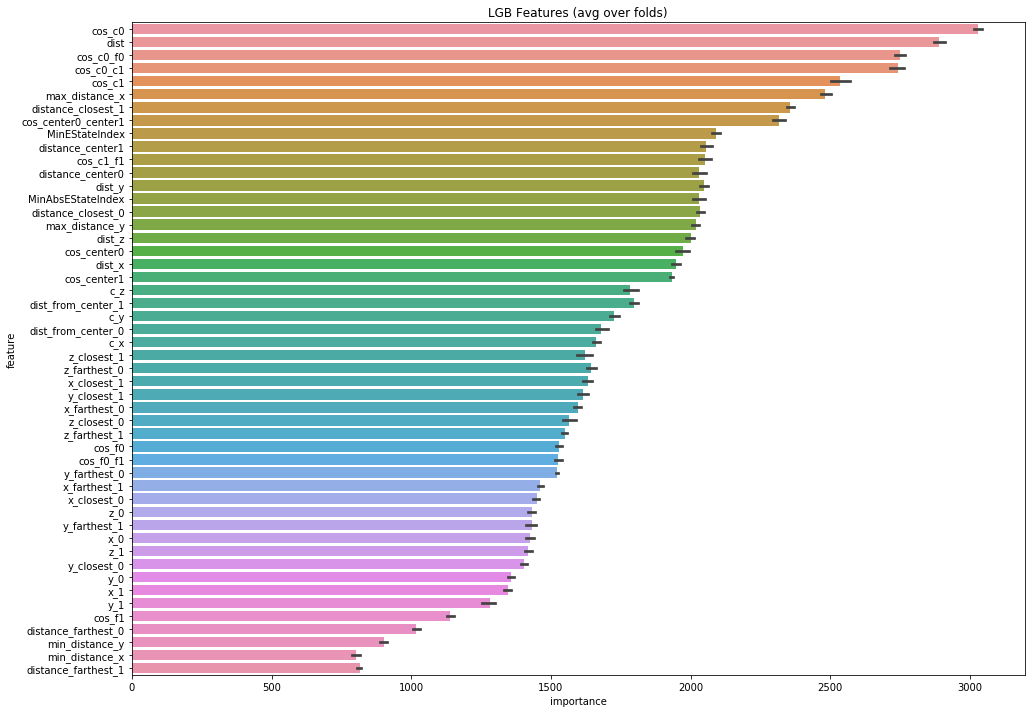

In [39]:
#Run
CV_score = 0

for t in train_merged['type'].unique():
    type_ = lbl.inverse_transform([t])[0]
    print(f'\nTraining of type {t}: {type_}.')
    index_type = (train_merged['type'] == t)
    index_type_test = (test_merged['type'] == t)
    
    X_t = x_train.loc[index_type].copy()
    X_test_t = x_test.loc[index_type_test].copy()
    y_t = y_train[index_type]
    
    #print(f'Generating features...')
    #start_time = time.time()
    
    ## Generating features from the public kernels, just by type
    ## no memory reduction is needed
    #X_t = get_features(X_t, structures.copy())
    #X_t = X_t[good_columns].fillna(0.0)
    
    #X_test_t = get_features(X_test_t, structures.copy())
    #X_test_t = X_test_t[good_columns].fillna(0.0)
    
    ## load Giba's features just for type t by getting rows to be excluded when initiating read_csv
    #rows_to_exclude = np.where(index_type==False)[0]+1 # retain the header row
    #rows_to_exclude_test = np.where(index_type_test==False)[0]+1
    #train_giba_t = pd.read_csv('../input/giba-molecular-features/train_giba.csv/train_giba.csv',
    #                    header=0, skiprows=rows_to_exclude, usecols=giba_columns)
    #test_giba_t = pd.read_csv('../input/giba-molecular-features/test_giba.csv/test_giba.csv',
    #                   header=0, skiprows=rows_to_exclude_test, usecols=giba_columns)
    
    #X_t = pd.concat((X_t, train_giba_t), axis=1)

    #X_test_t = pd.concat((X_test_t,test_giba_t), axis=1) 
    
    #del train_giba_t, test_giba_t
    #gc.collect()
    
    #print(f'Done in {(time.time() - start_time):.2f} seconds for {X_t.shape[1]} features.')
    ## feature generation done
    
    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds, 
                                              model_type='lgb', 
                                              eval_metric='mae', 
                                              plot_feature_importance=True,
                                              verbose=500, early_stopping_rounds=200, 
                                              n_estimators=n_estimators[t])
    del X_t, X_test_t
    gc.collect()
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
    ## manually computing the cv score
    CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types

In [40]:
#sample_submission = pd.read_csv('sample_submission.csv')

#benchmark = sample_submission.copy()
#benchmark['scalar_coupling_constant'] = result_dict_lgb_oof['prediction']
#benchmark.to_csv('LGBM_submission.csv',index=False)

sub['scalar_coupling_constant'] = X_short_test['prediction']
#today = str(datetime.date.today())
sub.to_csv('LightGBM_190720.csv', index=False)

In [41]:
#benchmark.head()

plot_data = pd.DataFrame(train_merged['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb['oof']
plot_data['type'] = train['type']

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)